In [8]:
import cv2
import os
import numpy as np
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking, Dropout, BatchNormalization,Bidirectional
from sklearn.decomposition import PCA
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model



In [2]:
originals = './test_data/originals'
deepfakes = './test_data/deepfakes'

In [3]:
BaseOptions = mp.tasks.BaseOptions
FaceDetector = mp.tasks.vision.FaceDetector
FaceDetectorOptions = mp.tasks.vision.FaceDetectorOptions
VisionRunningMode = mp.tasks.vision.RunningMode

# Create a face detector instance with the video mode:
detector_options = FaceDetectorOptions(
    base_options=BaseOptions(model_asset_path='./models/detector.tflite'),
    running_mode=VisionRunningMode.VIDEO)

In [60]:
def edge_detection(vid_path, fps, t_lower, t_upper, encoding_dim=1000, epochs=5, batch_size=256):
    video = cv2.VideoCapture(vid_path)
    original_fps = video.get(cv2.CAP_PROP_FPS)

    if fps > original_fps:
        interval = 1
    else:
        interval = int(original_fps / fps)

    frame_count = 0

    edge_diffs = []
    timestamps = []

    previous_frame = None

    with vision.FaceDetector.create_from_options(detector_options) as detector:
        while video.isOpened():
            ret, frame = video.read()

            if not ret:
                break

            if frame_count % interval == 0:
                # timestamp
                frame_timestamp = int(video.get(cv2.CAP_PROP_POS_MSEC))
                # frame
                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                mp_frame = mp.Image(image_format=mp.ImageFormat.SRGB, data=frame_rgb)
                # detect
                detect = detector.detect_for_video(mp_frame, frame_timestamp)

                if detect.detections:
                    for detection in detect.detections:
                        bbox = detection.bounding_box
                        start_x = int(bbox.origin_x)
                        start_y = int(bbox.origin_y)
                        end_x = int(bbox.origin_x + ((bbox.width*0.1) + bbox.width))
                        end_y = int(bbox.origin_y + ((bbox.height*0.1)+bbox.height))
                        
                        # Crop the face region
                        current_frame = frame[start_y:end_y, start_x:end_x]

                        if previous_frame is not None:
                            current_frame_resized = cv2.resize(current_frame, (previous_frame.shape[1], previous_frame.shape[0]))
                            # Compare edges across consecutive frames
                            edges_prev = cv2.Canny(previous_frame, t_lower, t_upper)
                            edges_curr = cv2.Canny(current_frame_resized, t_lower, t_upper)
                            diff = cv2.absdiff(edges_prev, edges_curr)

                            # Flatten the frame and normalize
                            diff_flat = diff.flatten() / 255.0

                            # Store the flattened edge difference
                            edge_diffs.append(diff_flat)
                            timestamps.append(frame_timestamp)

                        previous_frame = current_frame

                if len(edge_diffs) > 14: # get the first 15 frames only
                    break
            # Add a delay and exit mechanism
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

            frame_count += 1

        video.release()
        cv2.destroyAllWindows()

    if edge_diffs:
        max_length = max(len(diff) for diff in edge_diffs)
        edge_diffs = [np.pad(diff, (0, max_length - len(diff)), 'constant') for diff in edge_diffs]
        edge_diffs = np.array(edge_diffs)

        
        timestamps = np.array(timestamps).reshape(-1, 1)
        combined = np.hstack((edge_diffs, timestamps))
        
        return edge_diffs, timestamps, combined
    else:
        return np.array([])  # Return an empty array if no edge differences were computed

In [25]:
x = edge_detection(vid_path='./test_data/originals/001.mp4', fps=15, t_lower=50, t_upper=150)

In [30]:
print(x[0].shape)

(36482,)


In [36]:
def load_data(originals, deepfakes, fps, t_lower, t_upper):
    X_edge_differences = [] 
    y = []

    for video_path in os.listdir(originals):
        relative_path = os.path.join(originals, video_path)
        result = edge_detection(vid_path=relative_path, fps=fps, t_lower=t_lower, t_upper=t_upper)
        if result.size == 0:
            continue 
        print(f"Original video {video_path} result shape: {result.shape}")
        X_edge_differences.append(result)
        y.append(0)
    
    print("ORIGINALS DONEEEEE")

    for video_path in os.listdir(deepfakes):
        relative_path = os.path.join(deepfakes, video_path)
        
        result = edge_detection(vid_path=relative_path, fps=fps, t_lower=t_lower, t_upper=t_upper)
        if result.size == 0:
            continue 
        print(f"Deepfake video {video_path} result shape: {result.shape}")
        X_edge_differences.append(result)
        
        y.append(1)

    # Find the maximum length of the second dimension
    max_length = max(result.shape[1] for result in X_edge_differences)
    print(f"Max length of second dimension: {max_length}")

    # Pad each element to ensure they all have the same shape
    X_edge_differences_padded = []
    for result in X_edge_differences:
        pad_width = max_length - result.shape[1]
        padded_result = np.pad(result, ((0, 0), (0, pad_width)), mode='constant')
        print(f"Padded result shape: {padded_result.shape}")
        X_edge_differences_padded.append(padded_result)


    return np.array(X_edge_differences_padded), np.array(y)

In [37]:
X, y = load_data(originals='./test_data/originals', deepfakes='./test_data/deepfakes', fps=15, t_lower=50, t_upper=150)

c:\dev\thesis2\deepfake_manipulation_detection\venv\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


Original video 000.mp4 result shape: (15, 18497)
Original video 001.mp4 result shape: (15, 36482)
Original video 002.mp4 result shape: (15, 60026)
Original video 003.mp4 result shape: (15, 13226)
Original video 004.mp4 result shape: (15, 38417)
Original video 005.mp4 result shape: (15, 14642)
Original video 006.mp4 result shape: (15, 63002)
Original video 007.mp4 result shape: (15, 8465)
Original video 008.mp4 result shape: (15, 10001)
Original video 009.mp4 result shape: (15, 36482)
Original video 010.mp4 result shape: (15, 13226)
Original video 011.mp4 result shape: (15, 71825)
Original video 012.mp4 result shape: (15, 12997)
ORIGINALS DONEEEEE
Deepfake video 186_170.mp4 result shape: (15, 151322)
Deepfake video 434_438.mp4 result shape: (15, 19045)
Deepfake video 435_456.mp4 result shape: (15, 44945)
Deepfake video 436_526.mp4 result shape: (15, 43682)
Deepfake video 437_360.mp4 result shape: (15, 150545)
Deepfake video 438_434.mp4 result shape: (15, 21610)
Deepfake video 439_441.mp

In [44]:
print(X.shape)

(26, 15, 151322)


In [45]:
def build_autoencoder(input_dim, encoding_dim):
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(encoding_dim, activation='relu')(input_layer)
    decoded = Dense(input_dim, activation='sigmoid')(encoded)
    
    autoencoder = Model(inputs=input_layer, outputs=decoded)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    
    encoder = Model(inputs=input_layer, outputs=encoded)
    return autoencoder, encoder


In [46]:
def train_autoencoder(X, encoding_dim=1000, epochs=50, batch_size=256):
    input_dim = X.shape[2]  # 10000 features
    autoencoder, encoder = build_autoencoder(input_dim, encoding_dim)
    X_flat = X.reshape(-1, input_dim)  # Flatten the data for training
    autoencoder.fit(X_flat, X_flat, epochs=epochs, batch_size=batch_size, shuffle=True)
    return encoder


In [47]:
def compress_data_with_encoder(X, encoder):
    input_dim = X.shape[2]
    X_flat = X.reshape(-1, input_dim)  # Flatten the data for encoding
    X_compressed_flat = encoder.predict(X_flat)
    X_compressed = X_compressed_flat.reshape(X.shape[0], X.shape[1], -1)  # Reshape back to original structure
    return X_compressed


In [50]:
# Train the autoencoder
encoding_dim = 1000
epochs = 10
batch_size = 256
encoder = train_autoencoder(X, encoding_dim, epochs, batch_size)

Epoch 1/10


KeyboardInterrupt: 

In [49]:
# Compress the data
X_compressed = compress_data_with_encoder(X, encoder)
print(f"Shape of X after compression: {X_compressed.shape}")  # Should be (26, 15, 1000)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Shape of X after compression: (26, 15, 100)


In [53]:
X_train, X_test, y_train, y_test = train_test_split(X_compressed, y, test_size=0.2)

In [54]:
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (20, 15, 100)
Shape of y_train: (20,)
Shape of X_test: (6, 15, 100)
Shape of y_test: (6,)


In [55]:
# Define the enhanced LSTM model
model2 = Sequential()

# Add LSTM layers with more units and dropout for regularization
model2.add(LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model2.add(Dropout(0.2))
model2.add(LSTM(64, return_sequences=False))
model2.add(Dropout(0.2))

# Add a Batch Normalization layer
model2.add(BatchNormalization())

# Add Dense layers with Dropout
model2.add(Dense(64, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(32, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(1, activation='sigmoid'))

# Compile the model
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model2.summary()

c:\dev\thesis2\deepfake_manipulation_detection\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 15, 128)        │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 15, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 173,185 (676.50 KB)

 Trainable params: 173,057 (676.00 KB)

 Non-trainable params: 128 (512.00 B)

In [57]:
history = model2.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.7500 - loss: 0.6837 - val_accuracy: 1.0000 - val_loss: 0.6263
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.5000 - loss: 0.8972 - val_accuracy: 1.0000 - val_loss: 0.6300
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.5000 - loss: 0.7841 - val_accuracy: 1.0000 - val_loss: 0.6317
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.5625 - loss: 0.6410 - val_accuracy: 0.7500 - val_loss: 0.6546
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.6250 - loss: 0.7203 - val_accuracy: 0.7500 - val_loss: 0.6635
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.5625 - loss: 0.6451 - val_accuracy: 0.5000 - val_loss: 0.6643
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.6875 - loss: 0.5118 - val_accuracy: 0.5000 - val_loss: 0.6578
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.5000 - loss: 0.6472 - val_accuracy: 0.7500 - val_loss: 0.6

In [58]:
# Evaluate the model on the test set
test_loss, test_acc = model2.evaluate(X_test, y_test, verbose=1)
print(f'Test Accuracy: {test_acc}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6667 - loss: 0.6464
Test Accuracy: 0.6666666865348816


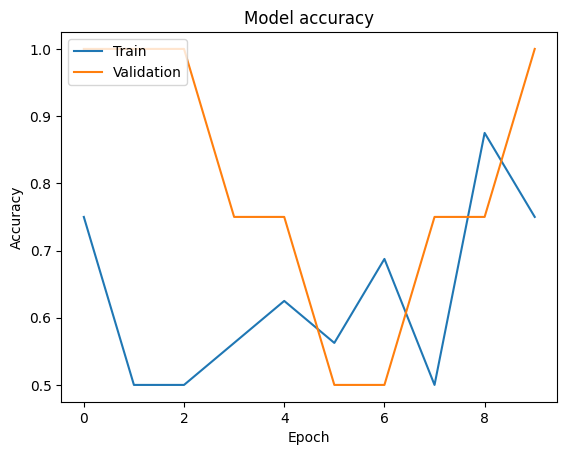

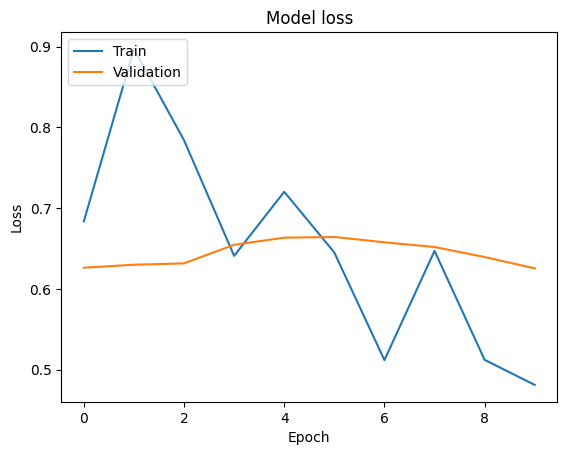

In [59]:
# Plot training & validation accuracy and loss
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()